## 0.0 IMPORTS

In [419]:

import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
from matplotlib import pyplot as plt
import os
from IPython.core.display import HTML
from IPython.display import Image
from datetime import datetime
from tabulate import tabulate
from scipy import stats as ss


### 0.1 HELPER FUNCTIONS


In [144]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()


Populating the interactive namespace from numpy and matplotlib


C:\Users\Heithor\anaconda3\envs\ds_em_producao\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### 0.2 LOADING DATA

In [145]:

df_sales_raw = pd.read_csv('datasets\\train.csv',low_memory=False)
df_store_raw = pd.read_csv('datasets\\store.csv',low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [146]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.0 DESCRICAO DOS DADOS

In [147]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [148]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

### 1.2 Data Dimensions


In [149]:
print('Numeber of Rows: {}'.format(df1.shape[0]))
print('Numeber of Cols: {}'.format(df1.shape[1]))

Numeber of Rows: 1017209
Numeber of Cols: 18


### 1.3 Data Types

In [150]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.1 Check NA

In [151]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [152]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)# competition_open_since_month  

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year      
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year   
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval    
month_map = {1: 'Jan',2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

### 1.6 Change Types

In [153]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

### 1.7  Descriptive Statistical

In [154]:
num_attributes = df1.select_dtypes(include = ['float64','int64'])
cat_attributes = df1.select_dtypes(exclude = ['float64','int64','datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [155]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
#Dispercion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.min)).T
d2 = pd.DataFrame(num_attributes.apply(np.max)).T
d3 = pd.DataFrame(num_attributes.apply(np.std)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis)).T

m1 = pd.concat([d1,d2,d4,ct1,ct2,d3,d5,d6]).T.reset_index()
m1.columns = ['attributes','min','max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


C:\Users\Heithor\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

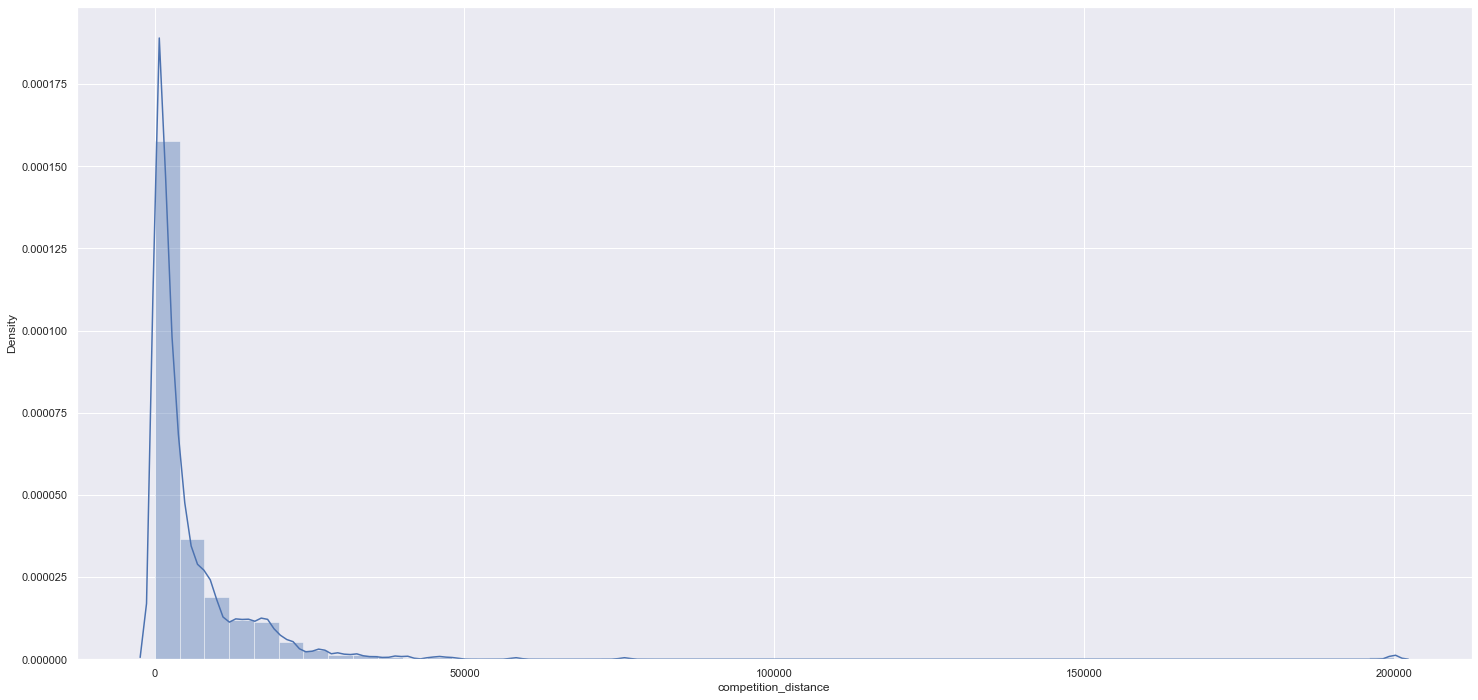

In [156]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [157]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

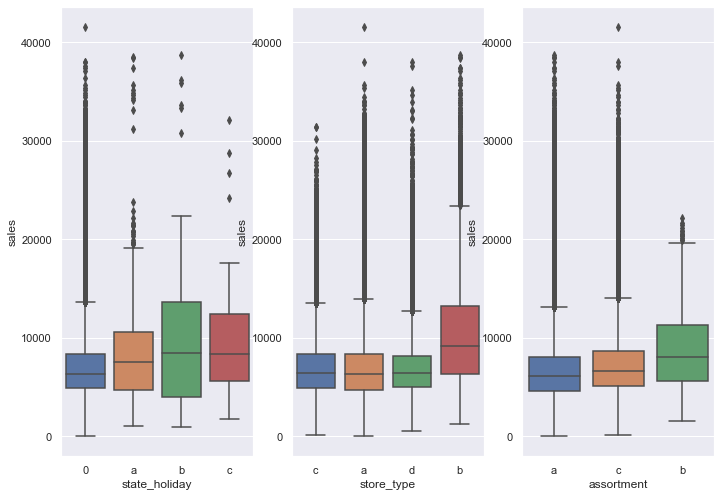

In [158]:
aux1= df1[(df1['state_holiday'] !=0) & (df1['sales']>0)]
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

## 2.0. PASSO 02 - FEATURE ENGINEERING


In [159]:
df2 = df1.copy()

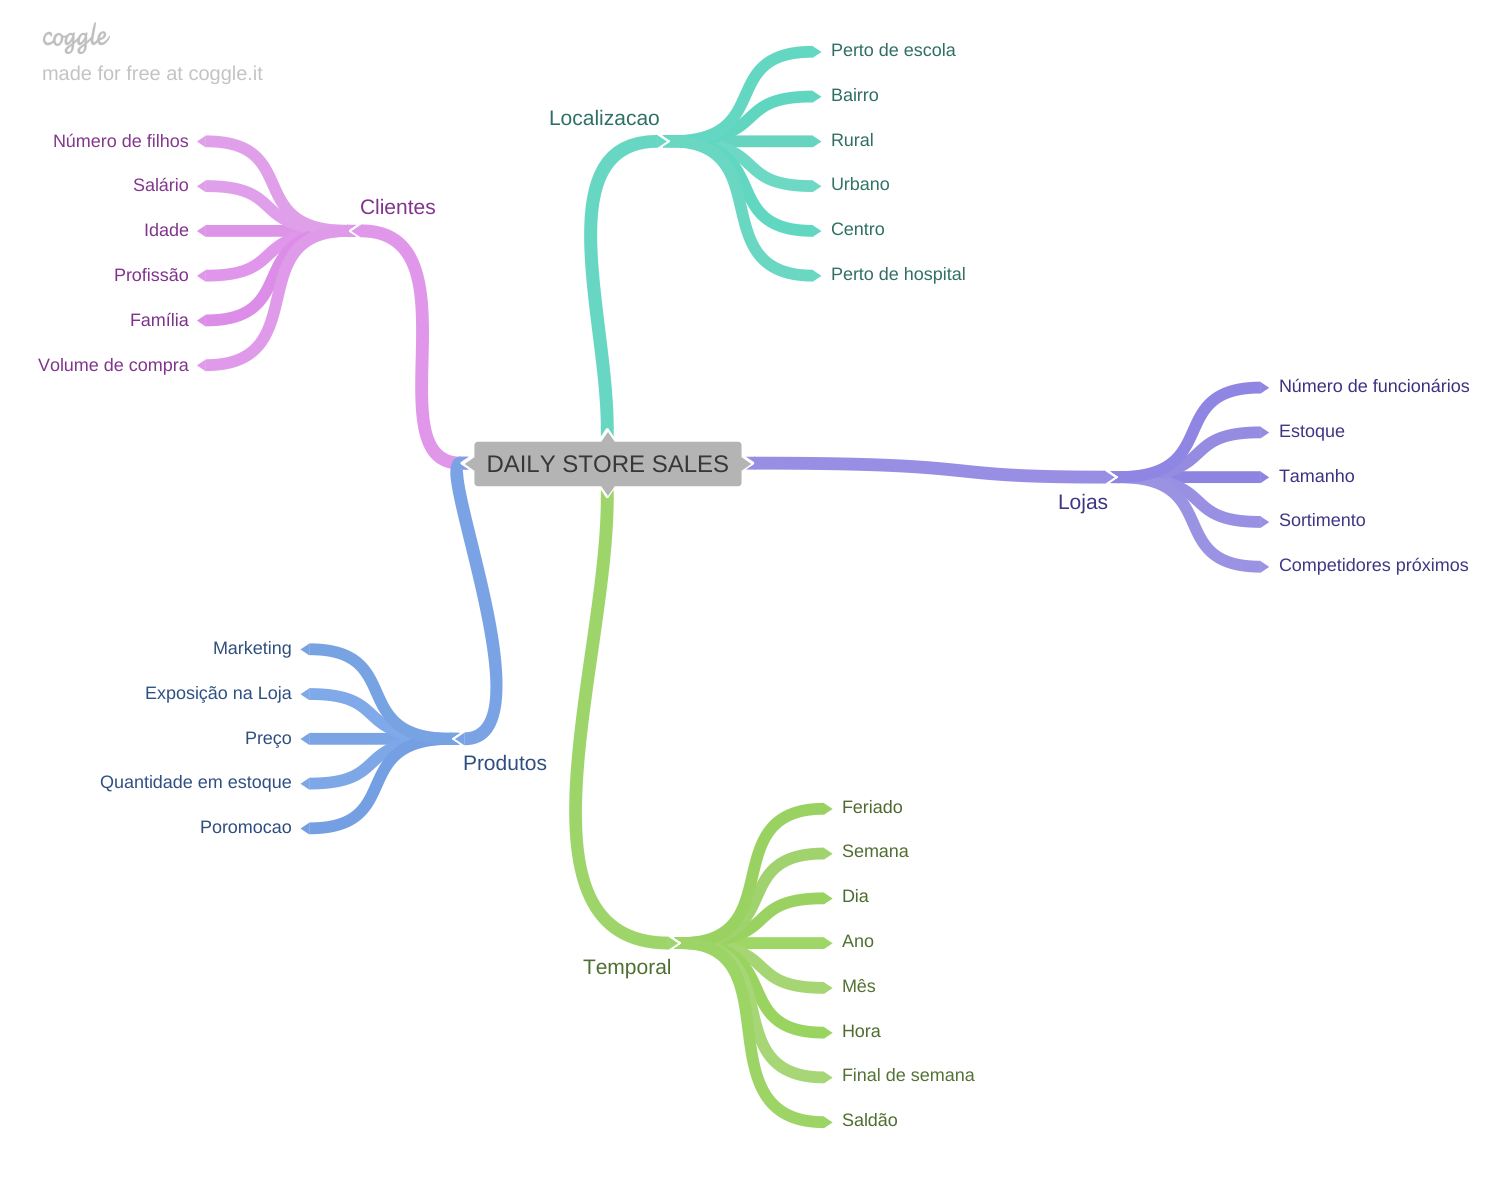

In [160]:
Image('img//mindmap_hyposis.png')

### 2.1. Criação das Hipóteses 

### 2.1.1. Hipóteses Loja


**1. Lojas com número maior de funcionários deveriam vender mais.**

**2. Lojas com maior capacidade de estoque deveriam vender mais.**

**3. Lojas com maior porte deveriam vender mais.**

**4. Lojas com maior sortimentos deveriam vender mais.**

**5. Lojas com competidores mais próximos deveriam vender menos.**

**6. Lojas com competidores à mais tempo deveriam vendem mais.**


### 2.1.2. Hipóteses Produto


**1. Lojas que investem mais em Marketing deveriam vender mais.**

**2. Lojas com maior exposição de produto deveriam vender mais.**

**3. Lojas com produtos com preço menor deveriam vender mais.**

**5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.**

**6. Lojas com promoções ativas por mais tempo deveriam vender mais.**

**7. Lojas com mais dias de promoção deveriam vender mais.**

**8. Lojas com mais promoções consecutivas deveriam vender mais.**


### 2.1.3. Hipóteses Tempo



**1. Lojas abertas durante o feriado de Natal deveriam vender mais.**

**2. Lojas deveriam vender mais ao longo dos anos.**

**3. Lojas deveriam vender mais no segundo semestre do ano.**

**4. Lojas deveriam vender mais depois do dia 10 de cada mês.**

**5. Lojas deveriam vender menos aos finais de semana.**

**6. Lojas deveriam vender menos durante os feriados escolares.**


### 2.2 Hipóteses Finais

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.



### 2.3 Feature Engineering

In [161]:
#year 
df2['year'] = df2['date'].dt.year

#month 
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#weer of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x=='a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day')

## 3.0. PASSO 0 - FILTRAGEM DE VARIÁVEIS

In [162]:
df3=df2.copy()

### 3.1. Filtragem de linhas

In [163]:
df3 = df3[(df3['sales']>0) & df3['open']==1]


### 3.2. Filtragem de colunas

In [164]:

df3 = df3.drop(['open', 'customers', 'promo_interval', 'month_map'], axis=1)

## 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [165]:
df4 = df3.copy()

### 4.1 Análise Univariada


##### 4.1.1 Response Variable


C:\Users\Heithor\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


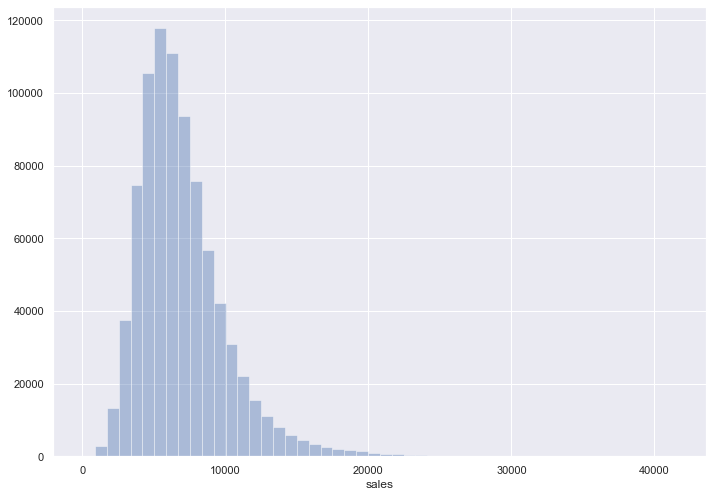

In [166]:
sns.distplot(df4['sales'], kde=False);

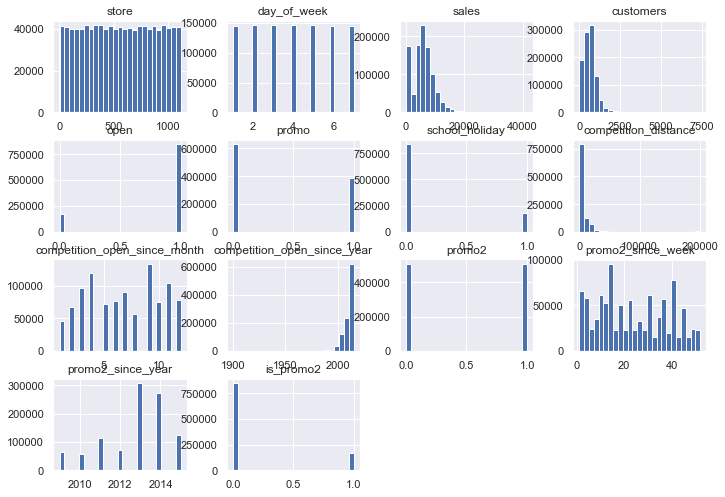

In [167]:
num_attributes.hist(bins=25);

#### 4.1.3. Categorical Variables

C:\Users\Heithor\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Heithor\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Heithor\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

<AxesSubplot:xlabel='sales', ylabel='Density'>

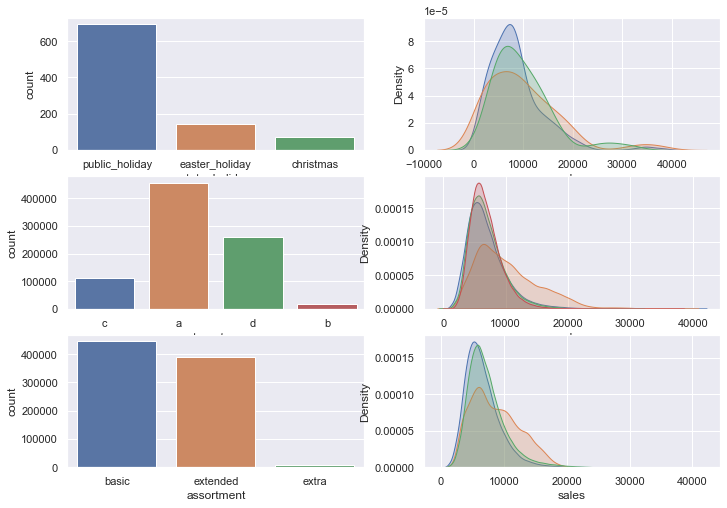

In [168]:

plt.subplot(3,2,1)
a = df4[df4['state_holiday']!='regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
#sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday' ]['sales'], label='public_holiday', shade=True);

sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )


#store type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )




### 4.2. Análise Bivariada

#### **H1.** Lojas com maior sortimentos deveriam vender mais.

**FALSO** Lojas com MAIOR SORTIMENTOS vendem MENOS


<AxesSubplot:xlabel='year_week'>

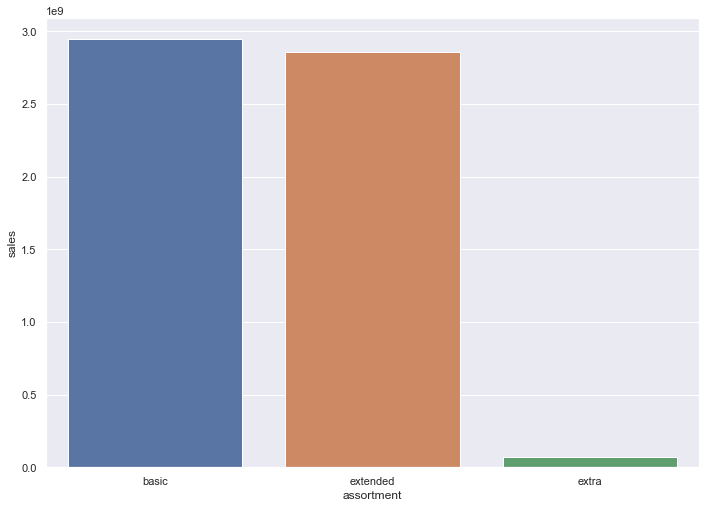

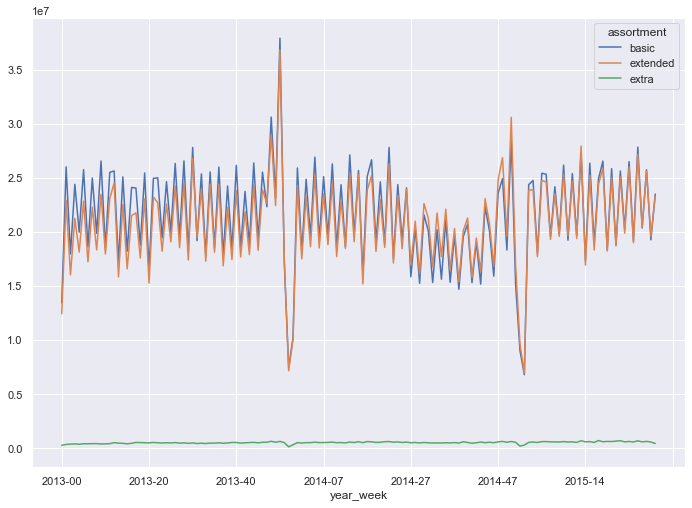

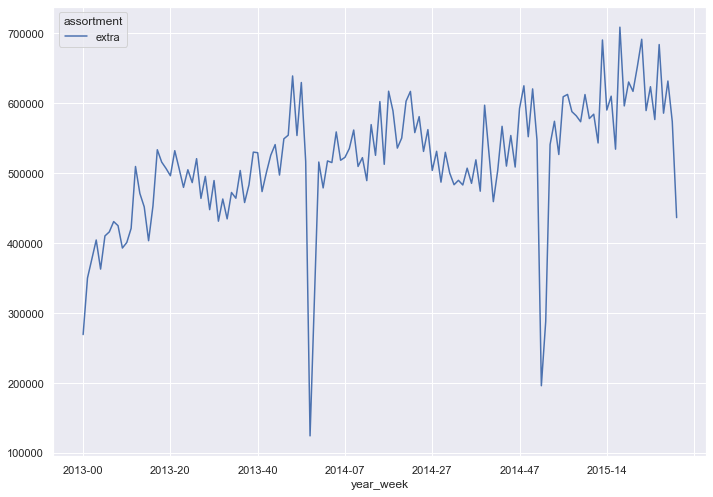

In [169]:
#sales vs assortment
aux1 = df4[['sales', 'assortment']].groupby('assortment').sum().reset_index()
sns.barplot( y='sales', x ='assortment', data=aux1);

#sales vs assortment & year_week
aux2 = df4[['sales', 'assortment', 'year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns='assortment', values='sales').plot()

#sales vs year_week in extra assortment
aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index = 'year_week', columns='assortment', values='sales').plot()

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSO** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

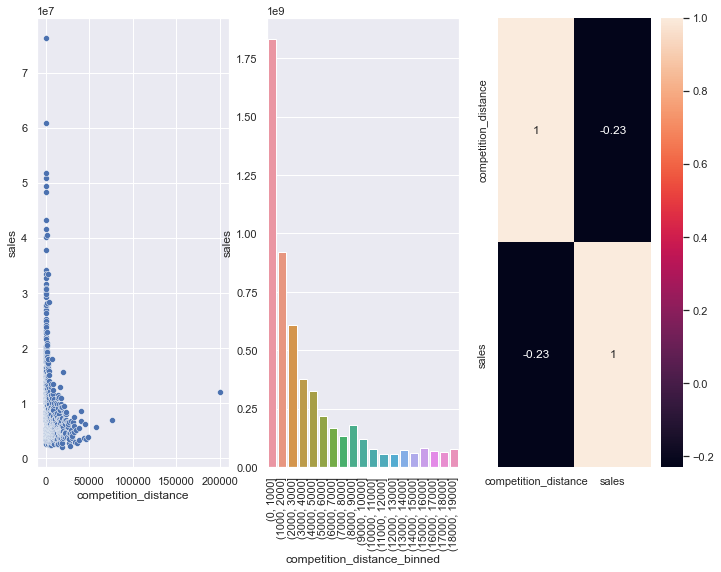

In [192]:
plt.subplot(1,3,1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

#agrupate bins 
plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['sales', 'competition_distance_binned']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );



#### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**FALSO** Lojas com competidores à MAIS TEMPO vendem MENOS


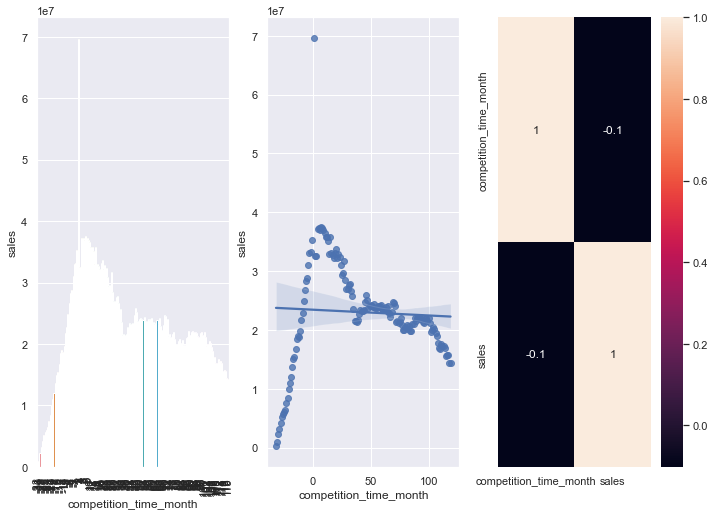

In [212]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['sales', 'competition_time_month']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month']!=0) ]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

#
plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

#heaat map to see the correlation
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );


#### **H4**. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

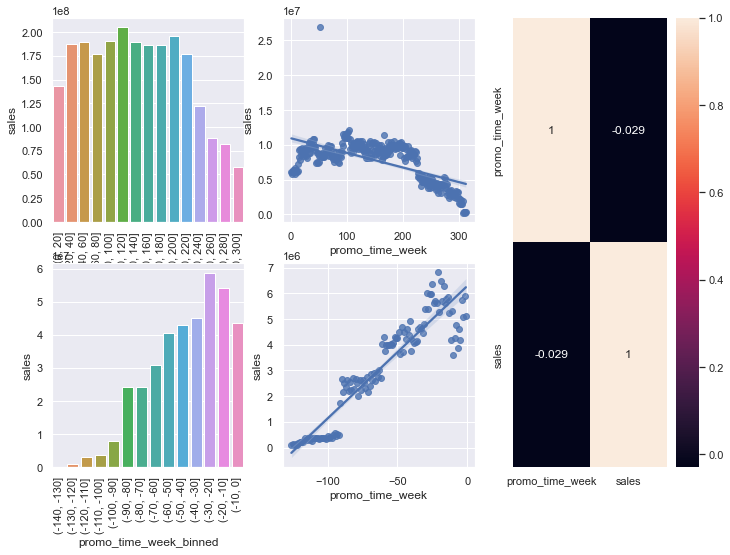

In [268]:

#promo extendida
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot(grid[0,0])
bins = list(np.arange(0,320,20))
aux1['promo_time_week_binned'] = pd.cut(aux1['promo_time_week'], bins=bins)
aux2 = aux1[['sales', 'promo_time_week_binned']].groupby('promo_time_week_binned').sum().reset_index()
sns.barplot(x='promo_time_week_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

# aux2 = aux1[aux1['promo_time_week']>0]
# plt.subplot(grid[0,0])
# sns.barplot(x='promo_time_week',y='sales', data=aux2);
# plt.xticks(rotation=90);

plt.subplot(grid[0,1])
aux2 = aux1[aux1['promo_time_week']>0]
sns.regplot(x='promo_time_week',y='sales', data=aux2);

#promo regular
plt.subplot(grid[1,0])
bins = list(np.arange(-140,1,10))
aux3['promo_time_week_binned'] = pd.cut(aux3['promo_time_week'], bins=bins)
aux4 = aux3[['sales', 'promo_time_week_binned']].groupby('promo_time_week_binned').sum().reset_index()
sns.barplot(x='promo_time_week_binned', y='sales', data=aux4);
plt.xticks(rotation=90);
# plt.subplot(grid[1,0])
# aux3 = aux1[aux1['promo_time_week']<0]
# sns.barplot(x='promo_time_week',y='sales', data=aux3);
# plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales', data=aux3);

#heatmap of all items
plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );



#### **H5.** Lojas com mais dias de promoção deveriam vender mais.

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSO** Lojas com MAIS PROMOÇÕES CONSECUTIVAS vendem MENOS

In [293]:
df4[['sales', 'promo', 'promo2']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


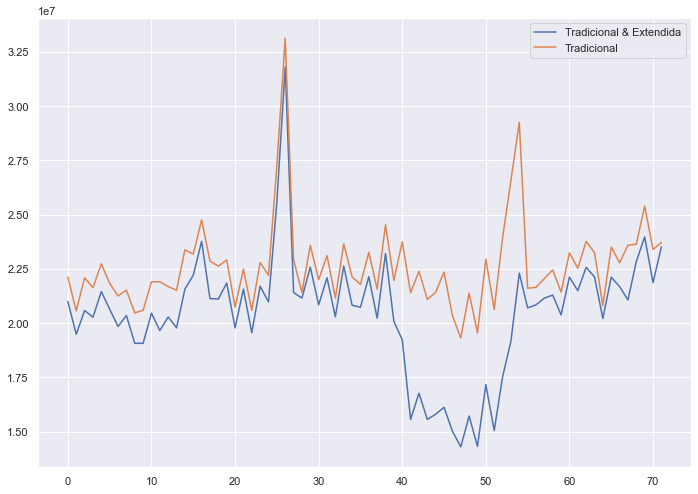

In [298]:

#Tradicional 
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax= aux1.plot()

#Tradicional & Extendida
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

#legendas
ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);


#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

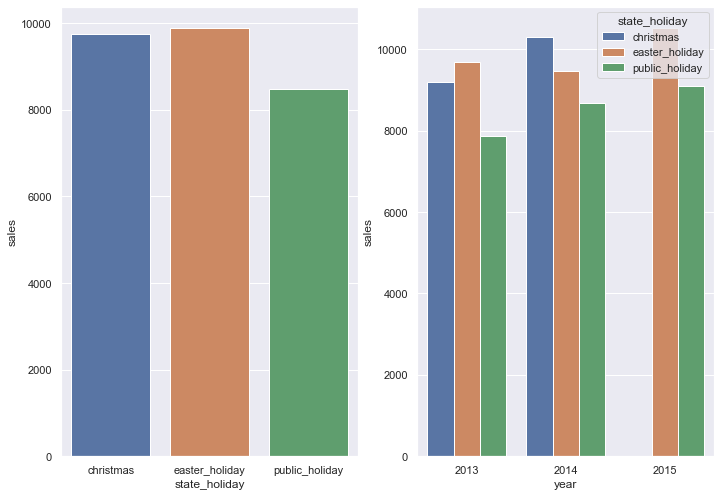

In [396]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['state_holiday','year']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday',data=aux2);


#### **H8.** Lojas deveriam vender mais ao longo dos anos.

**FALSO** As lojas vendem MENOS ao longo dos anos



<AxesSubplot:>

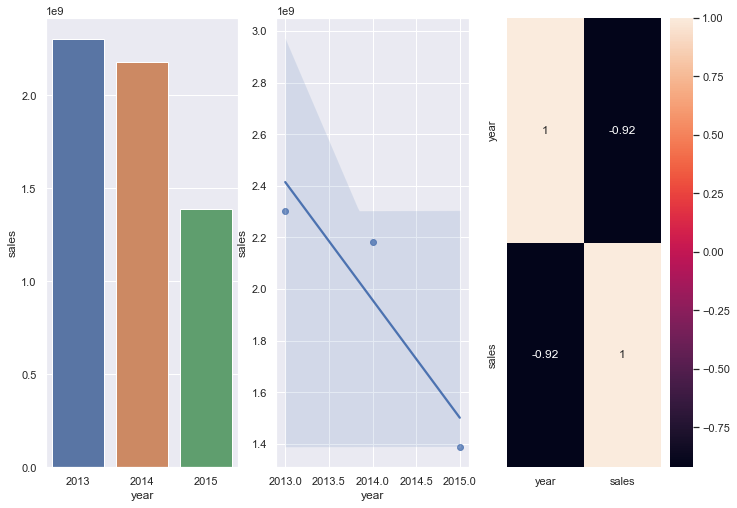

In [358]:
plt.subplot(1,3,1)
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux);

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)



#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

**FALSO** Lojas vendem MENOS no SEGUNDO SEMESTRE do ano

<AxesSubplot:>

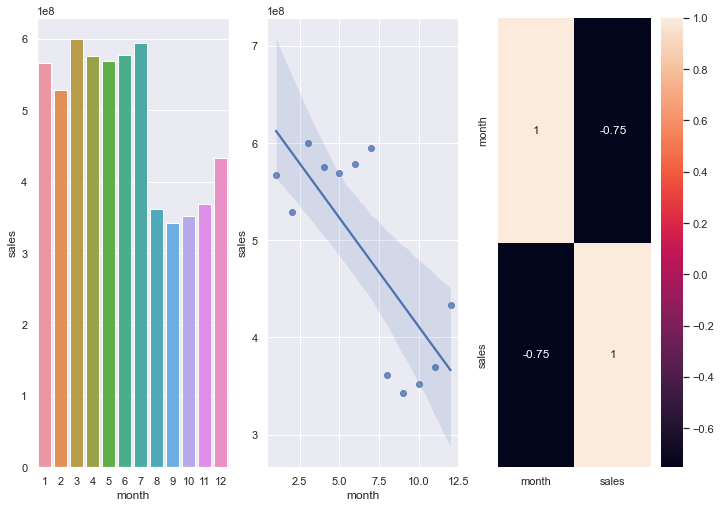

In [366]:
#barplot
plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)



#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADE** Lojas vedem mais depois do dia 10 de cada mês

<AxesSubplot:xlabel='before_after', ylabel='sales'>

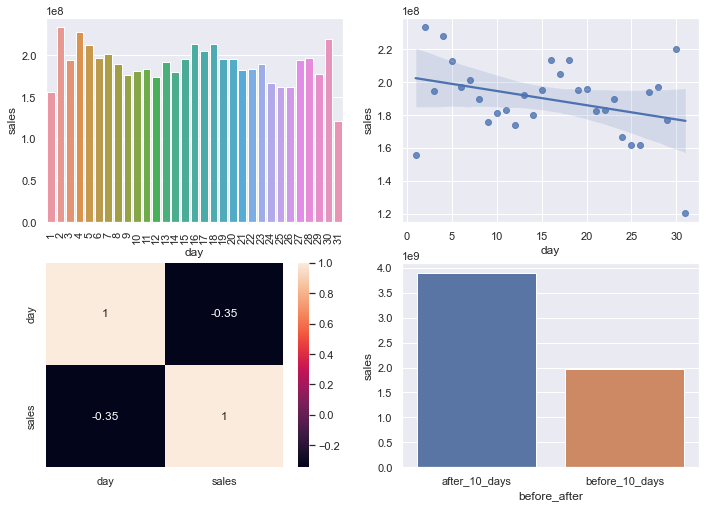

In [379]:
plt.subplot(2,2,1)
aux1 = df4[['sales', 'day']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'after_10_days' if x>10 else 'before_10_days')
aux2 = aux1[['sales', 'before_after']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2)


#### **H11.** Lojas deveriam vender menos aos finais de semana.

**VERDADE** Lojas vendem menos aos fins de semana

<AxesSubplot:>

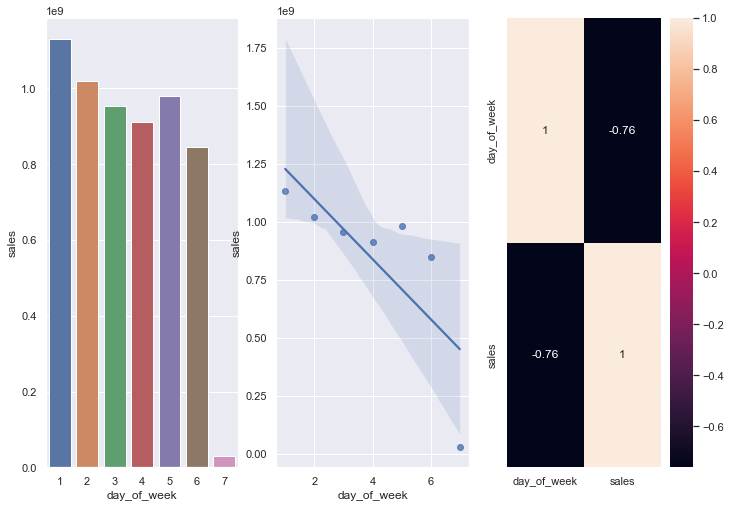

In [389]:
aux1 = df4[['sales', 'day_of_week']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)




#### **H12.** Lojas deveriam vender menos durante os feriados escolares.

**FALSO** Em média, as lojas vendem mais durante os feriados, mas a diferença é muito pequena

<AxesSubplot:xlabel='month', ylabel='sales'>

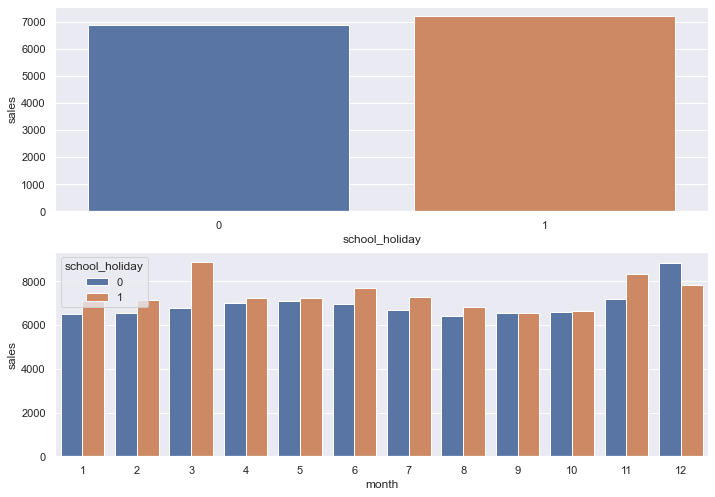

In [407]:
aux1 = df4[['sales', 'school_holiday']].groupby('school_holiday').mean().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['sales', 'school_holiday', 'month']].groupby(['school_holiday', 'month']).mean().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2)



#### 4.2.1. Resumo das Hipóteses

In [412]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


### 4.3. Análise Multivariada

#### 4.3.1. Numerical Attributes

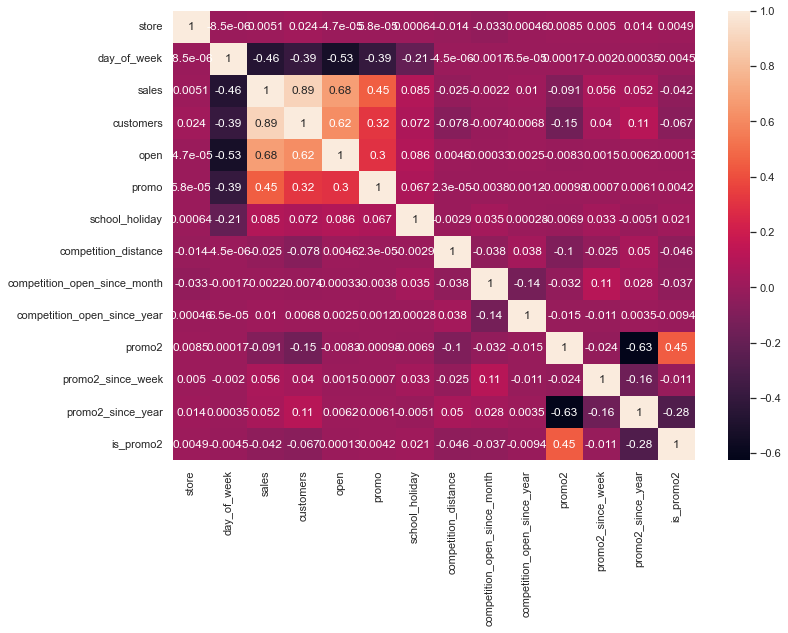

In [413]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

#### 4.3.2. Categorical Attributes

In [416]:
#only categorical data
a = df4.select_dtypes('object')

# Calculate cramer V


NameError: name 'cramer_v' is not defined

In [444]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
    

In [450]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9],
             })

d = d.set_index(d.columns)


,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

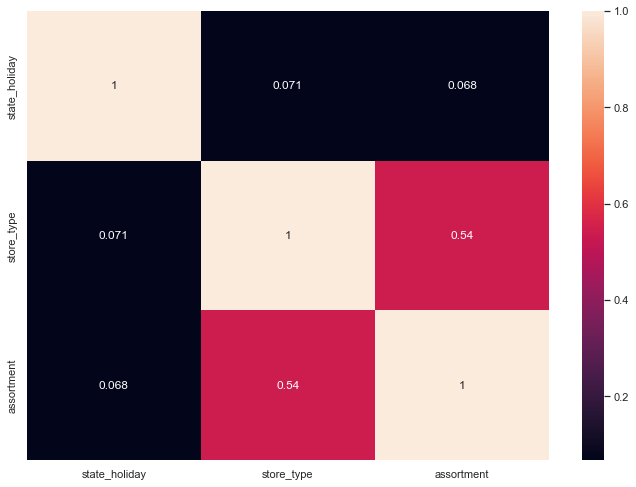

In [451]:
sns.heatmap(d, annot=True)